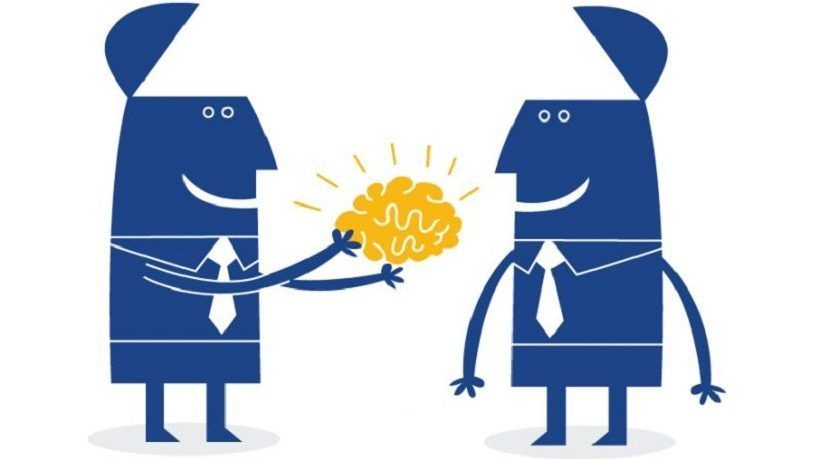

## Table of contents
* [1. Introduction](#introduction)
* [2. What is transfer learning](#what)
* [3. Importing libraries and data](#import)
* [4. Utility functions](#utility)
* [5. Create dataset](#dataset)
* [6. Creating Dataloaders](#data_loader)
* [7. Creating metric](#metric)
* [8. Transfer Learning](#transfer)
    * [8.1 Downloading model](#download)
    * [8.2 Freezing the model](#freeze)
    * [8.3 Creating final layer](#create)
* [9. Training](#train)
    * [9.1 Baseclass](#base)
    * [9.2 DataLoader](#dloader)
    * [9.3 Transfer learning model](#Tmodel)
    * [9.4 Training](#1epoch)
* [10. Conclusion](#conclusion)
* [11. Reference](#reference)

<a id="introduction"></a>
## 1. Introduction

For us humans if we learn something, similar things become easy. This is because we can apply our existing knowledge to the new tasks. One example of this is learning to ride a bycycle. If we know know to ride a bycycle, we can easly learn how to ride a motor bike. 

Similar to this there are many many CNN models availabe to us, which are pretrained in a tens of thousands of images. Instead of building everything from scratch, we can leverage the knowledge of these neural networks and modfy them according to our needs. This is called transfer learning. 

<a id="what"></a>
## 2. What is transfer learning ?

Transfer learning is a machine learning technique where knowledge gained during training in one type of problem is used to train in other, similar types of problem.<p/>
Thus, instead of building your own deep neural networks, which can be a cumbersome task to say the least, you can find an existing neural network that accomplishes the same task you’re trying to solve and reuse the layers that are essential for pattern detection, while also making changes to the fully connected layer to suit your problem.

<a id="import"></a>
## 3. Importing libraries and data

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv'   # Contains dummy labels for test image

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

<a id="utility"></a>
## 4. Utility functions

Below are some utility functions that we use in this notebook

In [4]:
def encode_label(label):
    #create an initial target which is all zeros
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))
    
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break
        
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

<a id="dataset"></a>
## 5. Create dataset

Lets create the dataset

In [5]:
class HumanProteinDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [6]:
transform = transforms.Compose([transforms.Resize(256), transforms.ToTensor()])
dataset = HumanProteinDataset(TRAIN_CSV, TRAIN_DIR, transform=transform)

In [7]:
torch.manual_seed(10)
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(17313, 1923)

<a id="data_loader"></a>
## 6. Creating Dataloaders

Lets create the dataloaders

In [8]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

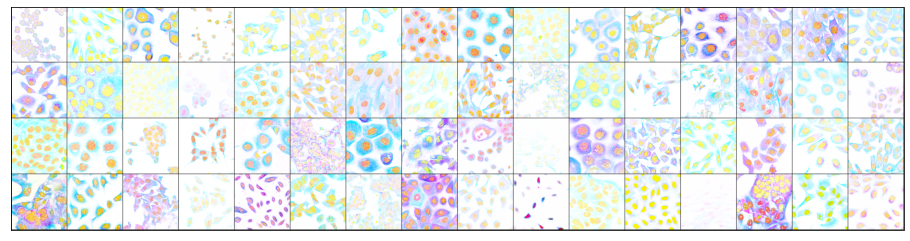

In [9]:
show_batch(train_dl)

<a id="metric"></a>
## 7. Creating metric

We are using the F2 score metric for calculating the validation score. 

In [10]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

<a id="transfer"></a>
## 8. Transfer Learning
<a id="download"></a>
### 8.1 Downloading model

We are going use the vgg16 pretrained model for transfer learning.

Lets download this pretrained model. pretrained=True will download a pretrained network for us.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=True)
vgg16 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We can see the last layer of this network, it contain three linear layers and with relu activation and three dropout layers. We remove this layer and put our own classifier layer.

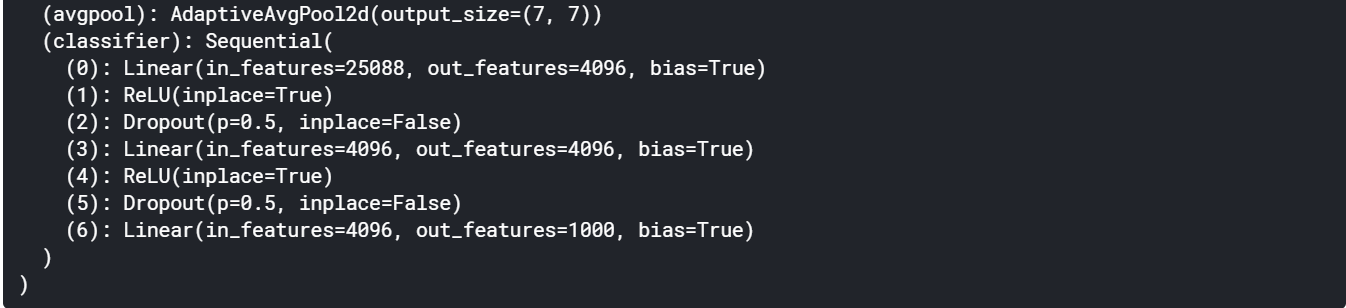

<a id="freeze"></a>
### 8.2 Freezing the model

The purpose of using a pretrained model is to avoid long training time. Here we dont need to train this entire model. Instead we are training only the layers that we add. So lets freeze the existing layers. We can freeze the model using the require_grad as false.

In [12]:
for param in vgg16.parameters():
  param.require_grad = False

<a id="create"></a>
### 8.3 Creating final layer

Lets create our own layer. For the purpose of this tutorial, I am creating some random layers.

In [13]:
fc = nn.Sequential(
    nn.Linear(25088, 5000),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(5000, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(1000, 460),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(460,10),
    
)

vgg16.classifier = fc
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Lets see how out model looks after adding the new layers. You can see that the input and the output of linear layers got changed.

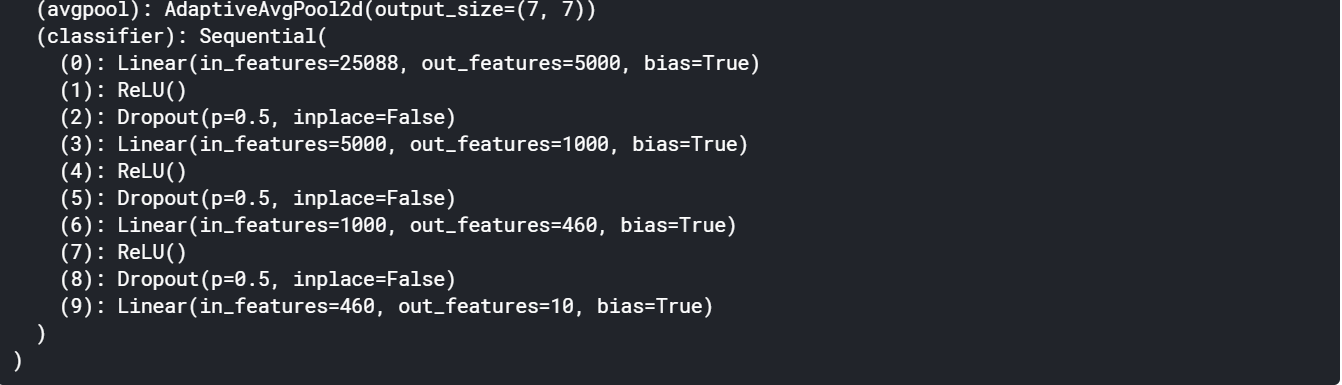

<a id="train"></a>
## 9. Training

Lets create a base class for the Image classification.

<a id="base"></a>
### 9.1 Baseclass

In [14]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

<a id="dloader"></a>
### 9.2 DataLoader

In [15]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

<a id="Tmodel"></a>
### 9.3 Transfer learning model

In [16]:
class TransferModel(MultilabelImageClassificationBase):
    def __init__(self, model):
        super().__init__()
        # Use a pretrained model
        self.network = model
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [19]:
from tqdm.notebook import tqdm
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = to_device(TransferModel(vgg16), device)

<a id="1epoch"></a>
### 9.4 Training

In [21]:
num_epochs = 1
opt_func = torch.optim.Adam
lr = .0001
fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.3473, val_loss: 0.2949, val_score: 0.4455


[{'val_loss': 0.294948011636734,
  'val_score': 0.445464164018631,
  'train_loss': 0.34728196263313293}]

Please dont mind the result. This was just an experiment to show how we can do transfer learning. You can create better classifiers using the b[eefier pretrained models.](https://pytorch.org/docs/stable/torchvision/models.html) 

<a id="conclusion"></a>
## 10 Conclusion

Transfer learning has several benefits, but the main advantages are  saving training time, better performance of neural networks (in most cases), and not needing a lot of data. 

Usually, a lot of data is needed to train a neural network from scratch but access to that data isn't always available — this is where transfer learning comes in handy. With transfer learning a solid machine learning model can be built with comparatively little training data because the model is already pre-trained.

Experiment with [beefier models](https://pytorch.org/docs/stable/torchvision/models.html) availabe with pytorch for better results.

<a id="reference"></a>
## 11 Reference

* https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/
* https://www.quora.com/What-is-the-VGG-neural-network
* https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch
* https://heartbeat.fritz.ai/transfer-learning-with-pytorch-cfcb69016c72